Задание 1 [4 балла].

Напишите функцию, на вход который поступает название города и которая выдает прогноз погоды на сегодня и завтра.
В прогноз включить температуру, осадки, влажность и скорость ветра.

In [181]:
#pip install requests 

In [2]:
import requests
import re
from bs4 import BeautifulSoup

# Пишем функцию, сообщающую о погоде, параметром которой явзяется город
def get_weather(weather_city):
    city_list='https://www.gismeteo.ru/catalog/russia/'
    city_response = requests.get(city_list, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
    soup = BeautifulSoup(city_response.text, 'html.parser')
    link='' # Опустошаем ссылку
    # Ищем город в цикле
    for a in soup.find_all('a', href=True, text=weather_city):
        city_link = a['href']
        link = 'https://www.gismeteo.ru' + city_link
    # Проверяем, запоонлилось ли поле
    if link=='':
        print(weather_city, "не найден на сайте.")
        return
    # Считываем страницу с прогнозом погоды
    weather_response = requests.get(link, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
    soup = BeautifulSoup(weather_response.text, 'html.parser')
    temp_today = [0] * 4 # Создаем 4 элемента массива: 2 значения температуры на сегодня и 2 на завтра
    i=0
    # Ищем строчки, в которых упоминается температура
    for temp in soup.find_all('span','unit unit_temperature_c'):
        # Пропускаем поле класса sign
        if temp.find_all(class_='sign'):
            continue
        else:
            temp_today[i] = temp.text
            i += 1
            # Прекращаем работу, когда получаем 4 значения
            if(i==4): 
                break
    # Ищем информацию об облачности и осадках на сегодня и на завтра
    for cond in soup.find_all('a',{"class": "weathertab weathertab-block tooltip"}):
        today_cond = cond['data-text'].replace('  ',' ')
        break
    for cond in soup.find_all('a',{"class": "weathertab weathertab-link tooltip"}):
        cond_tomorrow = cond['data-text'].replace('  ',' ')
        break
    today_hum = 0 # Обнуляем переменную влажности
    i = 0
    # Складываем все значения влажности за сегодня
    for hum in soup.find_all('div', {"class" :  re.compile("row-item item-.*")}):
        today_hum += int(hum.text)
        i += 1
    today_hum = int(today_hum/i) # Делим на количество показателей, чтобы получить среднее значение
    # Скорость ветра минимум и максимум
    today_wmin = 999 # Присваиваем минимуму значение, которое будет 100% выше возможного минимума ('0' может быть меньше)
    today_wmax = 0 # Присваиваем максимуму нулевое значение
    # Заполняем скорость ветра
    for cond in soup.find_all('span',{"class": "wind-unit unit unit_wind_m_s"}):
        x = cond.text
        ''' 
        Если лидирующий знак отрицательный (на gismeteo замечены такие кейсы) 
        или вместо скорости стоит прочерк, присваиваем значению '0' 
        '''
        if (x[0] == '-') | (x[0] == '—'):
            x[0] = '0'
        i = x.find('-') # Ищем дефис между двумя числами скорости ветра
        if i == -1: # Если второго числа нет - значит число одно
            x = int(x)
            today_wmin = min(today_wmin, x) # Заполняем минимальную скорость ветра
            today_wmax = max(today_wmax, x) # Заполняем максимальную сторость ветра
        else:
            # За минимум берем первое число конструкции, за максимум второе после дефиса
            x1 = int(x[0:i])
            x2 = int(x[i+1:])
            today_wmin = min(today_wmin, x1)
            today_wmax = max(today_wmax, x2)
            
    # Аналогичный цикл для завтрашней погоды (за исключением температуры и влажности, т.к. их получили ранее)
    link_tomorrow = link + 'tomorrow/'    
    weather_response = requests.get(link_tomorrow, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
    soup_tomorrow = BeautifulSoup(weather_response.text, 'html.parser')
    hum_tomorrow = 0
    i = 0
    for hum in soup_tomorrow.find_all('div', {"class" :  re.compile("row-item item-.*")}):
        hum_tomorrow += int(hum.text)
        i += 1
    hum_tomorrow = int(hum_tomorrow/i)
    tomorrow_wmin = 999
    tomorrow_wmax = 0
    for cond in soup_tomorrow.find_all('span',{"class": "wind-unit unit unit_wind_m_s"}):
        x = cond.text
        if (x[0] == '-') | (x[0] == '—'):
            x[0] = '0'
        i = x.find('-')
        if i == -1:
            x = int(x)
            tomorrow_wmin = min(tomorrow_wmin, x)
            tomorrow_wmax = max(tomorrow_wmax, x)
        else:
            x1 = int(x[0:i])
            x2 = int(x[i+1:])
            tomorrow_wmin = min(tomorrow_wmin, x1)
            tomorrow_wmax = max(tomorrow_wmax, x2)
   
    # Выводим условия задачи
    print(weather_city)
    print("Температура сегодня:", temp_today[0], "/", temp_today[1], "°C")
    print("Осадки сегодня:", today_cond)
    print("Влажность сегодня:", today_hum, "%")
    if today_wmin > 0:
        print("Скорость ветра сегодня: от", today_wmin, "до", today_wmax, "м/с")
    else:
        print("Скорость ветра сегодня: до", today_wmax, "м/с")
    print()
    print("Температура завтра", temp_today[2], "/", temp_today[3], "°C")
    print("Осадки завтра:", cond_tomorrow)
    print("Влажность завтра:", hum_tomorrow, "%")
    if tomorrow_wmin > 0:
        print("Скорость ветра завтра: от", tomorrow_wmin, "до", tomorrow_wmax, "м/с")
    else:
        print("Скорость ветра завтра: до", tomorrow_wmax, "м/с")
    print()
    print()

# Список городов
get_weather('Москва')
get_weather('Санкт-Петербург')
get_weather('Йошкар-Ола')

Москва
Температура сегодня: −4 / −2 °C
Осадки сегодня: Пасмурно, небольшой мокрый снег
Влажность сегодня: 82 %
Скорость ветра сегодня: от 1 до 11 м/с

Температура завтра −2 / 0 °C
Осадки завтра: Пасмурно, осадки
Влажность завтра: 83 %
Скорость ветра завтра: от 1 до 10 м/с


Санкт-Петербург
Температура сегодня: +2 / +3 °C
Осадки сегодня: Пасмурно, снег с дождём
Влажность сегодня: 86 %
Скорость ветра сегодня: от 3 до 12 м/с

Температура завтра 0 / +2 °C
Осадки завтра: Пасмурно
Влажность завтра: 87 %
Скорость ветра завтра: до 10 м/с


Йошкар-Ола
Температура сегодня: −16 / −10 °C
Осадки сегодня: Переменная облачность
Влажность сегодня: 74 %
Скорость ветра сегодня: от 3 до 9 м/с

Температура завтра −14 / −9 °C
Осадки завтра: Малооблачно
Влажность завтра: 80 %
Скорость ветра завтра: от 3 до 10 м/с




Задание 2 [2 балла].

Воспользуйтесь рейтингом фильмов - https://www.imdb.com/chart/top
Выгрузите ранг фильма, название, год и рейтинг.
1. Определите самое успешное десятилетие на основе среднего и максимального рейтинга фильмов (например, десятилетием является период 2010-2019 включительно). Постройте график.
2. Выведите таблицу в формате: Десятилетие - Самый успешый фильм этого десятилетия

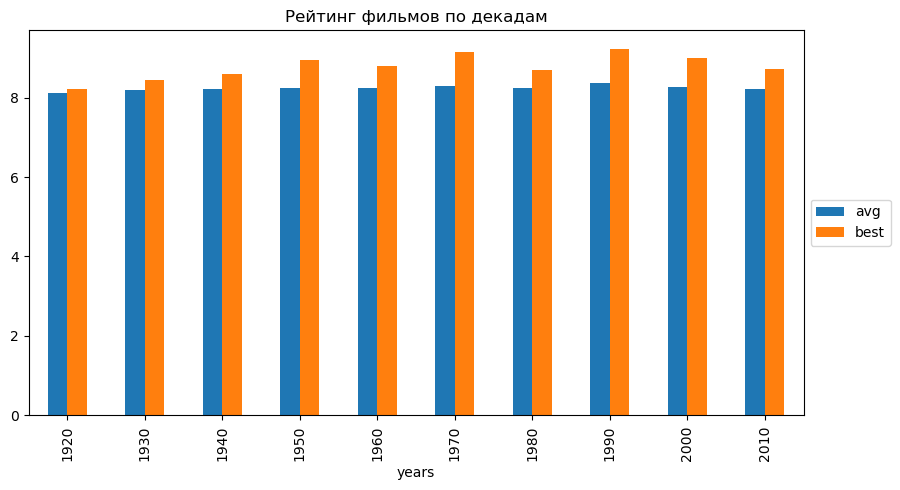

Самое успешное десятилетие на основе среднего рейтинга фильмов: 1990-1999
Самое успешное десятилетие на основании максимального рейтинга самого успешного фильма в нём: 1990-1999


,Десятилетие,Самый успешный фильм десятилетия
1,1920-1929,Метрополис
2,1930-1939,Новые времена
3,1940-1949,Эта замечательная жизнь
4,1950-1959,12 рaзгневанных мужчин
5,1960-1969,"Хороший, плохой, злой"
6,1970-1979,Крёстный отец
7,1980-1989,Звёздные войны Эпизод 5: Империя наносит ответный удар
8,1990-1999,Побег из Шоушенка
9,2000-2009,Темный рыцарь
10,2010-2019,Начало


In [183]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup
import sys
import matplotlib.pyplot as plt

START_YEAR = 1920 # Первый год самого раннего десятилетия, фильм которого входит в ТОП на данный момент
END_YEAR = 2020 # +1 к самому позднему году последнего десятилетия, т.к. десятилетие 2020-2029 ещё не закончилось

# Начальныая страница IMDB
imdb_url = 'https://www.imdb.com/chart/top/'

imdb_response = requests.get(imdb_url, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})

imdb_soup = BeautifulSoup(imdb_response.text, 'html.parser')

movies = imdb_soup.select('td.titleColumn') # Переменная для названий фильмов
ratings = [b.attrs.get('data-value') for b in imdb_soup.select('td.posterColumn span[name=ir]')] # Переменная для рейтингов
list = []
# Наполняем массивы
for index in range(0, len(movies)):
    movie_string = movies[index].get_text() # Берем изначальную строку
    movie = (' '.join(movie_string.split()).replace('.', '')) # Сплитим строку, убираем точки
    movie_title = movie[len(str(index))+1:-7] # Берем название фильма, отрезая начало года из конца
    year = int(re.search('\((.*?)\)', movie_string).group(1)) # Заполняем год
    # Формируем датасет
    data = {"movie_title": movie_title.strip(),
            "rating": ratings[index],
            "year": year
            }
    list.append(data)
ylist = [] # Обнуляем массив списка фильмов
i = START_YEAR
while i < END_YEAR:
    # Заполняем массив годами, счётчики пока оставляем пустыми
    ylist.append({"year": i, "avg_rating": 0.0, "best_rating": 0.0, "total_movies": 0, "best_movie": ""})
    i += 10 # Переход на след.десятилетие
for movie in list:
    # Просматриваем каждый фильм и добавляем параметры в соответствующую декаду
    if (movie['year'] >= START_YEAR) & (movie['year'] < END_YEAR):
        i = int((movie['year'] - movie['year'] % 10 - START_YEAR) / 10)
        tmp = float(movie['rating'])
        ylist[i]['avg_rating'] += tmp # Складываем рейтинги всех фильмов в переменную ср.рейтинга
        ylist[i]['total_movies'] += 1 # Увеличиваем количество фильмов
        ylist[i]['best_rating'] = max(ylist[i]['best_rating'],tmp) # Присваиваем наибольшее знач.рейтинга максимуму
        if ylist[i]['best_rating'] == tmp:
            ylist[i]['best_movie'] = movie['movie_title'] # Заполняем название для лучшего фильма
for year in ylist:
    if year['total_movies'] != 0: # Проверяем, были ли фильмы из ТОПа в том или ином десятилетии
        year['avg_rating'] /= float(year['total_movies']) # Получаем среднее, деля на количество фильмов

# Рисуем график с рейтингом
df[['years', 'avg', 'best']].plot(x='years', kind='bar',figsize=(10,5))
plt.title('Рейтинг фильмов по декадам', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
        
list_by_avg = sorted(ylist, key=lambda d: d['avg_rating'],reverse=True) # Сортируем по убыванию
print('Самое успешное десятилетие на основе среднего рейтинга фильмов:',
      str(list_by_avg[0]['year'])+'-'+str(list_by_avg[0]['year']+9)) # Выводим самую успешную декаду по ср.рейтингу
    
list_by_max = sorted(ylist, key=lambda d: d['best_rating'],reverse=True)
print('Самое успешное десятилетие на основании максимального рейтинга самого успешного фильма в нём:',
      str(list_by_max[0]['year'])+'-'+str(list_by_max[0]['year']+9)) # Выводим самую успешную декаду по лучшему рейтингу
df = pd.DataFrame({'years': [r['year'] for r in ylist],
 'avg': [r['avg_rating'] for r in ylist],
 'best': [r['best_rating'] for r in ylist]})

data = pd.DataFrame(columns=['Десятилетие', 'Самый успешный фильм десятилетия']) # Заголовки таблицы
      
data.loc[0] = ['','']
# Заполняем таблицу в цикле
for row in ylist:
    data.loc[len(data.index)] = [str(row['year'])+'-'+str(row['year']+9), row['best_movie']]
data = data[1:]
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
data

Задание 3 [4 балла].

Напишите скрипт, который будет нажимать на случайную внутреннюю ссылку на странице Википедии. Внутренней считается ссылка, которая ссылается на какую-то другую статью Википедии.
Ссылка должна быть из основного информационного блока. Функциональные ссылки из верхнего, бокового и нижнего меню в этой процедуре участвовать не должны.

На вход функции поступает число повторений этой процедуры. Переходы не прерываются, то есть при переходе на следующую статью следующая ссылка выбирается именно среди ссылок этой статьи.

Выведите путь (последовательность) по названиям статей, которые встретились в процессе перехода по страницам.

In [184]:
import requests
from random import randrange,seed
from urllib.parse import urlparse, urljoin
import urllib
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium import webdriver

URL_PREFIX = 'https://ru.wikipedia.org'

driver = webdriver.Chrome()

# Пишем функцию для клика в рандомную ссылку внутри статьи
def wiki_click():
    url = urllib.parse.unquote(driver.current_url)
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    title = soup.find('title')
    print(title.text)

    wikiArticle = soup.findAll('div', id = "mw-content-text") # Часть страницы, относящаяся к статье
    #wikiArticle = soup.findAll('div', id = "bodyContent")
    internal_url = [] # Создаем пустой массив внутренних ссылок
    for row in wikiArticle:
        # Ищем в цикле внутренние ссылки
        for link in row.findAll('a',href=True):
            tmp_url = link['href']
            if tmp_url.startswith('/wiki/'): # Проверяем начало ссылки 
                internal_url.append(tmp_url)
    ok = 0 
    # Проверяем удалось ли найти "живую" (не скрытую и рабочую) ссылку
    if len(internal_url) == 0:
        print("Тупиковая статья, нет внутренних ссылок.")
        return 0
    while ok != 1: # Пока не попалась "живая" ссылка
        if len(internal_url) > 2:
            x = randrange(len(internal_url)) # Берём рандомную
        else:
            x = 0
        ids = driver.find_elements(By.XPATH,'//*[@href]') # Ищем элементы, являющиеся ссылками
        # Ищем ссылку на которую хотим перейти
        for link in ids:
            tmp = link.get_attribute('href')
            # Проверяем, видна ли ссылка на экране
            if link.is_displayed():
                if URL_PREFIX+internal_url[x] == tmp:
                    link.click() # Клик по ссылке
                    ok = 1
                    break
    return 1

# Функция, получающая на вход количество активных кликов
def wiki_clicks(counter):
        while counter != 0:
            if wiki_click() == 1:
                counter -= 1
            else:
                break

seed(0) # Чтобы всегда получать идентичный результат
driver.get(URL_PREFIX+'/wiki/ВКонтакте') # Начинаем с ВК :)
wiki_clicks(10) # Число кликов
driver.quit()

ВКонтакте — Википедия
РИА Новости — Википедия
Дело Pussy Riot — Википедия
Московская школа фотографии и мультимедиа имени Родченко — Википедия
Лаврентьев, Александр Николаевич — Википедия
Московский Союз художников — Википедия
Глухов, Виктор Александрович — Википедия
Сотбис — Википедия
Торонто — Википедия
Янг-стрит — Википедия
